# Model - Word Embedding

In [1]:
import pyspark

sparkConfig = {
    'spark.executor.memory': '30g',
    'spark.driver.memory': '60g',
    'spark.master': 'local[*]',
    'spark.default.parallelism': '30',
}
sc = pyspark.SparkContext('local[*]', 'Model - Word Embedding')

In [2]:
import datetime
import importlib
import json
import numpy as N
import numpy.random as NR
import matplotlib.pyplot as pyplot
import seaborn
import pandas as P
from pathlib import Path
import shutil
import pyspark.mllib as SM
import pyspark.mllib.feature as SMF
import tqdm
import pickle

seaborn.set_style('whitegrid')

In [3]:
import common.twitter
pathChirps = Path('datasets/Chirps')
pathAnalyticsChirp = Path('analytics/Chirps')
substituteFlag = True # If true, substitute before split(' ')
pathOccTrain = pathAnalyticsChirp / 'token_occurrence_train.csv'
pathOccTest = pathAnalyticsChirp / 'token_occurrence_test.csv'

## Generate histogram

In [4]:

def count_tokens(instances):
    def extract_tokens(l):
        x = common.twitter.chirps_instance_readhalfline(l)
        if substituteFlag:
            x = x.tokenised_substitute_string
        else:
            x = x.tokenised_string
        return [(y,1) for y in x]

    occ = sc.textFile(str(instances)) \
        .flatMap(extract_tokens) \
        .reduceByKey(lambda a,b: a+b, numPartitions=90) \
        .sortBy(lambda x:-x[1]) \
        .collect()
    print(f"{len(occ)} distinct tokens collected")

    occ = P.DataFrame(occ, columns=['token', 'frequency'])
    return occ

if pathOccTrain.exists():
    occTrain = P.read_csv(pathOccTrain)
else:
    occTrain = count_tokens(pathChirps / 'instances_train.tsv')
    occTrain.to_csv(pathOccTrain, index=False)
    
    
if pathOccTest.exists():
    occTest = P.read_csv(pathOccTest)
else:
    occTest = count_tokens(pathChirps / 'instances_test.tsv')
    occTest.to_csv(pathOccTest, index=False)

print(f"Train: {len(occTrain)} distinct tokens collected")
print(f"Test: {len(occTest)} distinct tokens collected")

Train: 281368 distinct tokens collected
Test: 120542 distinct tokens collected


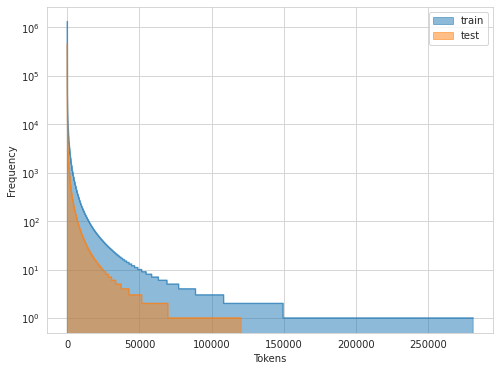

In [5]:
    
fig, ax = pyplot.subplots(figsize=(8,6))
ax.plot(occTrain['frequency'], alpha=0.5, color='tab:blue')
ax.plot(occTest['frequency'], alpha=0.5, color='tab:orange')
ax.fill_between(range(len(occTrain)), occTrain['frequency'], alpha=0.5, color='tab:blue', label='train')
ax.fill_between(range(len(occTest)), occTest['frequency'], alpha=0.5, color='tab:orange', label='test')
ax.set_yscale('log')
ax.legend(loc='upper right')
ax.set_xlabel('Tokens')
ax.set_ylabel('Frequency')
fig.savefig(pathAnalyticsChirp / 'occ.png', dpi=300)

## Train Word2Vec embedding model

In [6]:
pathModelEmbedding = Path("models/embedding/word2vec")
properties = {
    'embedding_size': 128,
    'tweet_len': 26, # Determined from data exploration
}
with open(pathModelEmbedding / 'properties.json', 'w') as f:
    json.dump(properties, f)

In [7]:
if not pathModelEmbedding.exists():
    w2v = SMF.Word2Vec()\
        .setVectorSize(properties['embedding_size'])\
        .setSeed(0) \
        .setNumPartitions(8) \
        .setNumIterations(2)

    rdd = sc.textFile(str(pathChirps / 'instances_train.tsv')) \
        .map(common.twitter.chirps_instance_readhalfline) \
        .map(lambda x:x.tokenised_substitute_string if substituteFlag else x.tokenised_string)

    model = w2v.fit(rdd)
    model.save(sc, str(pathModelEmbedding))
    
    with open(pathModelEmbedding / 'properties.json', 'w') as f:
        json.dump(properties, f)
else:
    model = SMF.Word2VecModel.load(sc, str(pathModelEmbedding))
    
if (pathModelEmbedding / 'dict.pickle').exists():
    with open(pathModelEmbedding / 'dict.pickle', 'rb') as f:
        m = pickle.load(f)
else:
    m = dict(model.getVectors())
    m = {k:N.array(v) for k,v in tqdm.tqdm(m.items())}
    with open(pathModelEmbedding / 'dict.pickle', 'wb') as f:
        pickle.dump(m, f)

In [8]:
broadcastedM = sc.broadcast(m)

In [9]:
def embed_tweet(li):
    zero = N.zeros(properties['embedding_size'])
    li = [broadcastedM.value.get(x, zero) for x in li]
    dl = properties['tweet_len'] - len(li)
    assert dl >= 0
    li = N.stack(li)
    # Pad result so they all have 26 words.
    return N.pad(li, ((0, dl), (0,0)))
embed_tweet(["donald", "trump", "becomes", "president"])

array([[ 0.43980223, -0.09601658, -0.05356978, ..., -0.04555546,
         0.4592869 ,  0.05844319],
       [-0.12356465, -0.1183284 , -0.24127899, ..., -0.25358212,
         0.18620174, -0.1305861 ],
       [ 0.08329236, -0.07850468, -0.0141851 , ..., -0.10134368,
         0.15035576, -0.04029754],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Cache intermediate outputs from word embedding.

**Warning**: Disabled routine. This proves to be too memory inefficient. A better solution is to use word embedding in-place.

In [12]:
def read_tweet(x):
    x = common.twitter.chirps_instance_readhalfline(x)
    return x.tweetId, embed_tweet(x.tokenised_substitute_string)
def map_instances(name):
    """
    The purpose of this function is to prevent spark from pickling everything in the current scope.
    """
    rdd = sc.textFile(str(pathChirps / f'{name}.tsv'), 30) \
        .map(read_tweet)
    pOut = pathModelEmbedding / name
    if pOut.exists():
        shutil.rmtree(pathModelEmbedding / name)
    rdd.saveAsPickleFile(str(pOut))
#map_instances('instances_train')